In [ ]:
!pip install transformers
!pip install huggingface_hub
!pip install docling-core torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Cell 1: Import libraries and set up environment
import os
import time
import torch
import tempfile
import re
from PIL import Image
from pathlib import Path
from google.colab import userdata
import ipywidgets as widgets
from IPython.display import display, Markdown


HF_TOKEN = userdata.get("HF_TOKEN")

# Check for required packages and install if needed
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Try imports for Transformers
try:
    from transformers import AutoProcessor, AutoModelForVision2Seq
    from huggingface_hub import login
    transformers_available = True
except ImportError:
    print("Installing transformers and huggingface_hub...")
    install_package("transformers")
    install_package("huggingface_hub")
    from transformers import AutoProcessor, AutoModelForVision2Seq
    from huggingface_hub import login
    transformers_available = True

# Try imports for docling
try:
    from docling_core.types.doc import DoclingDocument
    from docling_core.types.doc.document import DocTagsDocument
    docling_available = True
except ImportError:
    print("Installing docling-core...")
    install_package("docling-core")
    from docling_core.types.doc import DoclingDocument
    from docling_core.types.doc.document import DocTagsDocument
    docling_available = True

# Check dependencies
print("Dependencies check: Transformers available:", transformers_available)
print("Dependencies check: Docling available:", docling_available)

Dependencies check: Transformers available: True
Dependencies check: Docling available: True


In [ ]:
# Cell 2: Define function to process single image
def process_single_image(image, prompt_text="Convert this page to docling."):
    """Process a single image"""
    # Authenticate with Hugging Face
    if HF_TOKEN:
        login(token=HF_TOKEN)
    else:
        print("WARNING: HF_TOKEN not found in .env file. Authentication may fail.")
        print("You can set it manually with: os.environ['HF_TOKEN'] = 'your_token_here'")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    start_time = time.time()

    # Load processor and model
    print("Loading model and processor...")
    try:
        processor = AutoProcessor.from_pretrained("ds4sd/SmolDocling-256M-preview")
        model = AutoModelForVision2Seq.from_pretrained(
            "ds4sd/SmolDocling-256M-preview",
            torch_dtype=torch.float32,
        ).to(device)
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        raise

    print("Processing image...")
    # Create input messages
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": prompt_text}
            ]
        },
    ]

    # Prepare inputs
    prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=prompt, images=[image], return_tensors="pt")
    inputs = inputs.to(device)

    # Generate outputs
    generated_ids = model.generate(**inputs, max_new_tokens=1024)
    prompt_length = inputs.input_ids.shape[1]
    trimmed_generated_ids = generated_ids[:, prompt_length:]
    doctags = processor.batch_decode(
        trimmed_generated_ids,
        skip_special_tokens=False,
    )[0].lstrip()

    # Clean the output
    doctags = doctags.replace("<end_of_utterance>", "").strip()

    # Populate document
    doctags_doc = DocTagsDocument.from_doctags_and_image_pairs([doctags], [image])

    # Create a docling document
    doc = DoclingDocument(name="Document")
    doc.load_from_doctags(doctags_doc)

    # Export as markdown
    md_content = doc.export_to_markdown()

    processing_time = time.time() - start_time

    return doctags, md_content, processing_time

In [ ]:
# Cell 3: Functions for file upload and display
def save_uploaded_file(uploaded_file):
    """Save an uploaded file to a temporary file and return the path"""
    with tempfile.NamedTemporaryFile(delete=False, suffix='.jpg') as tmp:
        tmp.write(uploaded_file.read())
        return tmp.name

def process_and_display_results(image, task_type):
    """Process an image and display the results"""
    try:
        doctags, md_content, processing_time = process_single_image(image, task_type)

        print(f"Processing completed in {processing_time:.2f} seconds")

        # Display results
        print("\n" + "="*50)
        print("DOCTAGS OUTPUT:")
        print("="*50)
        print(doctags)

        print("\n" + "="*50)
        print("MARKDOWN OUTPUT:")
        print("="*50)
        display(Markdown(md_content))

        # Return results for saving if needed
        return doctags, md_content

    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None, None


In [ ]:
# Cell 4: Upload and process a single image
from google.colab import files  # Only for Google Colab

# For Jupyter, comment out the Google Colab specific imports and use a different method
def upload_and_process_single():
    uploaded = files.upload()  # This is for Google Colab

    # For regular Jupyter Notebook, you would use ipywidgets FileUpload instead
    # upload_widget = widgets.FileUpload(accept='.jpg, .jpeg, .png', multiple=False)
    # display(upload_widget)
    # You'd then need to handle the upload_widget.value after user uploads

    if uploaded:
        filename = next(iter(uploaded))
        with tempfile.NamedTemporaryFile(delete=False, suffix='.jpg') as tmp:
            tmp.write(uploaded[filename])
            tmp_path = tmp.name

        image = Image.open(tmp_path).convert("RGB")

        # Display the uploaded image
        display(image)

        # Task selection
        task_types = [
            "Convert this page to docling.",
            "Convert this table to OTSL.",
            "Convert code to text.",
            "Convert formula to latex.",
            "Convert chart to OTSL.",
            "Extract all section header elements on the page."
        ]

        task_dropdown = widgets.Dropdown(
            options=task_types,
            value=task_types[0],
            description='Task Type:',
            style={'description_width': 'initial'}
        )
        display(task_dropdown)

        process_button = widgets.Button(description="Process Image")
        display(process_button)

        def on_process_button_clicked(b):
            print(f"Processing with task: {task_dropdown.value}")
            doctags, md_content = process_and_display_results(image, task_dropdown.value)

            # Save options
            if doctags and md_content:
                save_doctags = widgets.Button(description="Save DocTags")
                save_md = widgets.Button(description="Save Markdown")
                display(save_doctags)
                display(save_md)

                def save_doctags_file(b):
                    with open('output.dt', 'w') as f:
                        f.write(doctags)
                    files.download('output.dt')  # For Colab

                def save_md_file(b):
                    with open('output.md', 'w') as f:
                        f.write(md_content)
                    files.download('output.md')  # For Colab

                save_doctags.on_click(save_doctags_file)
                save_md.on_click(save_md_file)

        process_button.on_click(on_process_button_clicked)

In [ ]:
# Cell 5: Upload and process multiple images
def upload_and_process_multiple():
    uploaded = files.upload()  # This is for Google Colab

    if uploaded:
        # Task selection
        task_types = [
            "Convert this page to docling.",
            "Convert this table to OTSL.",
            "Convert code to text.",
            "Convert formula to latex.",
            "Convert chart to OTSL.",
            "Extract all section header elements on the page."
        ]

        task_dropdown = widgets.Dropdown(
            options=task_types,
            value=task_types[0],
            description='Task Type:',
            style={'description_width': 'initial'}
        )
        display(task_dropdown)

        process_button = widgets.Button(description=f"Process {len(uploaded)} Images")
        display(process_button)

        def on_process_button_clicked(b):
            images = []
            image_paths = []

            # Save uploaded files to temporary files
            for filename in uploaded.keys():
                with tempfile.NamedTemporaryFile(delete=False, suffix='.jpg') as tmp:
                    tmp.write(uploaded[filename])
                    tmp_path = tmp.name
                    image_paths.append(tmp_path)
                    images.append(Image.open(tmp_path).convert("RGB"))

            results = []
            for idx, image in enumerate(images):
                print(f"\nProcessing image {idx+1}/{len(images)}...")
                display(image)
                doctags, md_content = process_and_display_results(image, task_dropdown.value)
                if doctags and md_content:
                    results.append((doctags, md_content))

                    # Save individual files
                    with open(f'output_{idx+1}.dt', 'w') as f:
                        f.write(doctags)
                    with open(f'output_{idx+1}.md', 'w') as f:
                        f.write(md_content)

                    print(f"Files saved as output_{idx+1}.dt and output_{idx+1}.md")

            print("\nAll images processed successfully")

        process_button.on_click(on_process_button_clicked)

In [ ]:
def main():
    print("SmolDocling OCR Application")
    print("==========================")

    if not HF_TOKEN:
        print("WARNING: HF_TOKEN not found in .env file. Authentication may fail.")
        print("You can set it manually with: os.environ['HF_TOKEN'] = 'your_token_here'")

    # Create upload options
    upload_type = widgets.RadioButtons(
        options=['Single Image', 'Multiple Images'],
        value='Single Image',
        description='Upload type:',
        disabled=False
    )
    display(upload_type)

    process_button = widgets.Button(description="Continue")
    display(process_button)

    def on_button_clicked(b):
        if upload_type.value == 'Single Image':
            upload_and_process_single()
        else:
            upload_and_process_multiple()

    process_button.on_click(on_button_clicked)

Processing completed in 25.41 seconds

DOCTAGS OUTPUT:
<doctag><text><loc_226><loc_67><loc_274><loc_72>CERTIFICATE OF COMPLETION</text>
<text><loc_232><loc_112><loc_268><loc_117>CYBERSAGA TRAINING</text>
<text><loc_236><loc_188><loc_264><loc_194>Thiscertifiesthat</text>
<text><loc_242><loc_235><loc_258><loc_240>Abdullah</text>
<text><loc_207><loc_280><loc_292><loc_285>has successfully completed the cybersecurity scenario.</text>
<text><loc_230><loc_325><loc_270><loc_330>"The Unexpected Visitor"</text>
<text><loc_236><loc_370><loc_264><loc_375>with a score of 64%</text>
<text><loc_236><loc_416><loc_268><loc_421>Date: March 14, 2025</text>
<page_footer><loc_227><loc_464><loc_273><loc_469>CyberSaga Training Program</page_footer>
</doctag>

MARKDOWN OUTPUT:


CERTIFICATE OF COMPLETION

CYBERSAGA TRAINING

Thiscertifiesthat

Abdullah

has successfully completed the cybersecurity scenario.

"The Unexpected Visitor"

with a score of 64%

Date: March 14, 2025

CyberSaga Training Program

Button(description='Save DocTags', style=ButtonStyle())

Button(description='Save Markdown', style=ButtonStyle())

SmolDocling OCR Application


RadioButtons(description='Upload type:', options=('Single Image', 'Multiple Images'), value='Single Image')

Button(description='Continue', style=ButtonStyle())

Saving hoi hoi hoi.jpg to hoi hoi hoi.jpg


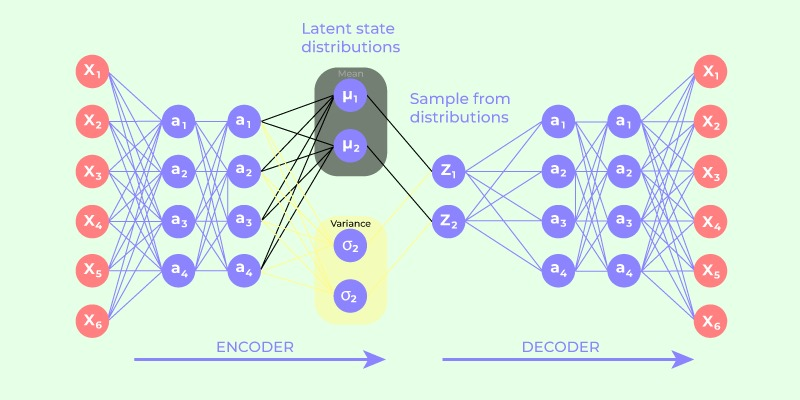

Dropdown(description='Task Type:', options=('Convert this page to docling.', 'Convert this table to OTSL.', 'C…

Button(description='Process Image', style=ButtonStyle())

Processing with task: Convert chart to OTSL.
Using device: cuda
Loading model and processor...


Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


Processing image...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Processing completed in 14.73 seconds

DOCTAGS OUTPUT:
<chart><loc_0><loc_0><loc_500><loc_500><flow_chart><fcel>Latent state distributions<fcel>X1<fcel>X2<fcel>X3<fcel>X4<fcel>X5<fcel>X6<fcel>X7<fcel>X8<fcel>X9<nl><fcel>a1<fcel>a1<fcel>a1<fcel>a1<fcel>a1<fcel>a1<fcel>a1<fcel>a1<fcel>a1<fcel>a1<nl><fcel>a2<fcel>a2<fcel>a2<fcel>a2<fcel>a2<fcel>a2<fcel>a2<fcel>a2<fcel>a2<fcel>a2<nl><fcel>a3<fcel>a3<fcel>a3<fcel>a3<fcel>a3<fcel>a3<fcel>a3<fcel>a3<fcel>a3<fcel>a3<nl><fcel>a4<fcel>a4<fcel>a4<fcel>a4<fcel>a4<fcel>a4<fcel>a4<fcel>a4<fcel>a4<fcel>a4<nl><fcel>a5<fcel>a5<fcel>a5<fcel>a5<fcel>a5<fcel>a5<fcel>a5<fcel>a5<fcel>a5<fcel>a5<nl><fcel>a6<fcel>a6<fcel>a6<fcel>a6<fcel>a6<fcel>a6<fcel>a6<fcel>a6<fcel>a6<fcel>a6<nl><fcel>a7<fcel>a7<fcel>a7<fcel>a7<fcel>a7<fcel>a7<fcel>a7<fcel>a7<fcel>a7<fcel>a7<nl><fcel>a8<fcel>a8<fcel>a8<fcel>a8<fcel>a8<fcel>a8<fcel>a8<fcel>a8<fcel>a8<fcel>a8<nl><fcel>a9<fcel>a9<fcel>a9<fcel>a9<fcel>a9<fcel>a9<fcel>a9<fcel>a9<fcel>a9<fcel>a9<nl></chart>

MARKDOWN OUTPUT:


Processing with task: Convert chart to OTSL.
Using device: cuda
Loading model and processor...


Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


Processing image...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Processing completed in 15.08 seconds

DOCTAGS OUTPUT:
<chart><loc_0><loc_0><loc_500><loc_500><flow_chart><fcel>Latent state distributions<fcel>X1<fcel>X2<fcel>X3<fcel>X4<fcel>X5<fcel>X6<fcel>X7<fcel>X8<fcel>X9<nl><fcel>a1<fcel>a1<fcel>a1<fcel>a1<fcel>a1<fcel>a1<fcel>a1<fcel>a1<fcel>a1<fcel>a1<nl><fcel>a2<fcel>a2<fcel>a2<fcel>a2<fcel>a2<fcel>a2<fcel>a2<fcel>a2<fcel>a2<fcel>a2<nl><fcel>a3<fcel>a3<fcel>a3<fcel>a3<fcel>a3<fcel>a3<fcel>a3<fcel>a3<fcel>a3<fcel>a3<nl><fcel>a4<fcel>a4<fcel>a4<fcel>a4<fcel>a4<fcel>a4<fcel>a4<fcel>a4<fcel>a4<fcel>a4<nl><fcel>a5<fcel>a5<fcel>a5<fcel>a5<fcel>a5<fcel>a5<fcel>a5<fcel>a5<fcel>a5<fcel>a5<nl><fcel>a6<fcel>a6<fcel>a6<fcel>a6<fcel>a6<fcel>a6<fcel>a6<fcel>a6<fcel>a6<fcel>a6<nl><fcel>a7<fcel>a7<fcel>a7<fcel>a7<fcel>a7<fcel>a7<fcel>a7<fcel>a7<fcel>a7<fcel>a7<nl><fcel>a8<fcel>a8<fcel>a8<fcel>a8<fcel>a8<fcel>a8<fcel>a8<fcel>a8<fcel>a8<fcel>a8<nl><fcel>a9<fcel>a9<fcel>a9<fcel>a9<fcel>a9<fcel>a9<fcel>a9<fcel>a9<fcel>a9<fcel>a9<nl></chart>

MARKDOWN OUTPUT:


Saving A-sample-prescription-image-in-grayscale-version.png to A-sample-prescription-image-in-grayscale-version.png


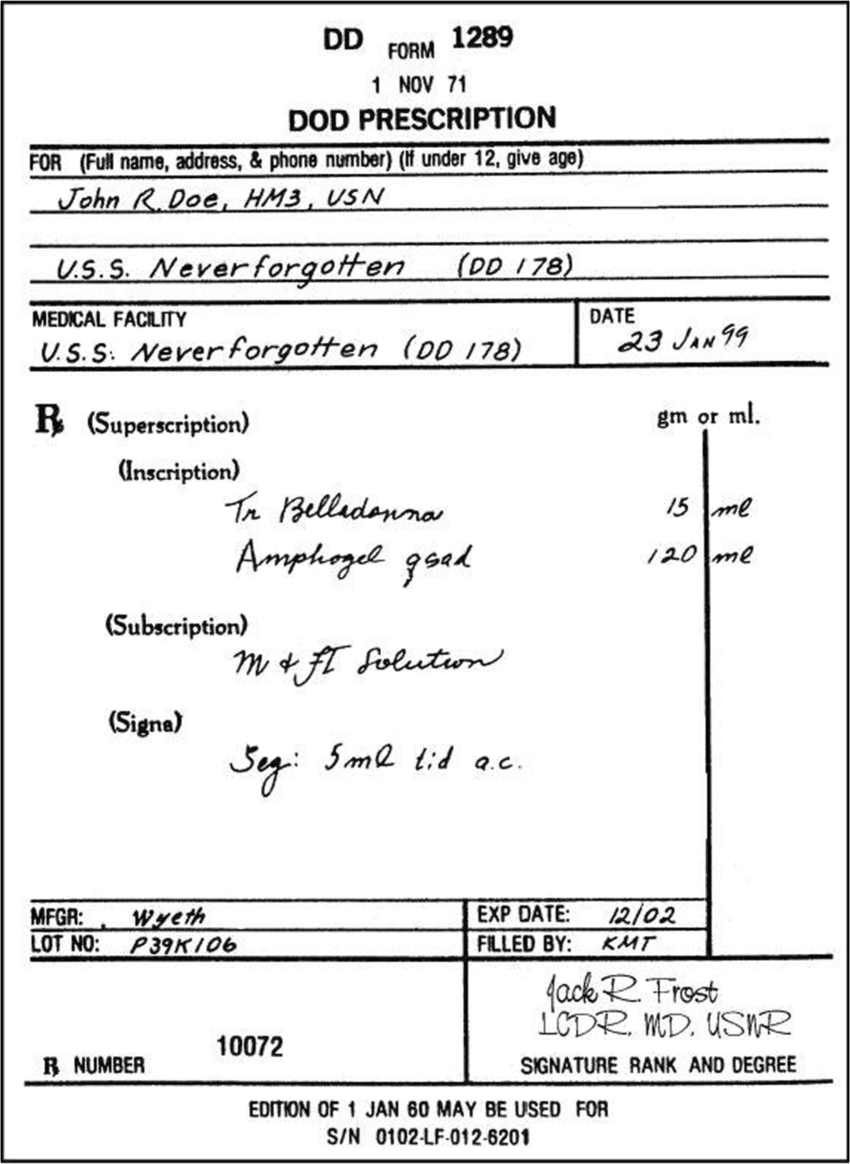

Dropdown(description='Task Type:', options=('Convert this page to docling.', 'Convert this table to OTSL.', 'C…

Button(description='Process Image', style=ButtonStyle())

Processing with task: Convert this page to docling.
Using device: cuda
Loading model and processor...


Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


Processing image...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Processing completed in 38.90 seconds

DOCTAGS OUTPUT:
<doctag><text><loc_185><loc_10><loc_209><loc_24>DD</text>
<text><loc_210><loc_10><loc_230><loc_24>FORM</text>
<text><loc_231><loc_10><loc_250><loc_24>1289</text>
<text><loc_210><loc_31><loc_230><loc_41>1</text>
<text><loc_231><loc_31><loc_250><loc_41>NOV</text>
<section_header_level_1><loc_167><loc_45><loc_248><loc_58>DOD PRESCRIPTION</section_header_level_1>
<text><loc_14><loc_63><loc_346><loc_75>FOR (Full name, address, & phone number) (If under 12, give age)</text>
<text><loc_14><loc_80><loc_223><loc_92>John R. Doe, HM3, USN</text>
<text><loc_14><loc_109><loc_259><loc_122>U.S.S. Neverforgotten (DD 178)</text>
<text><loc_14><loc_132><loc_112><loc_143>MEDICAL FACILITY</text>
<text><loc_343><loc_132><loc_375><loc_143>DATE</text>
<text><loc_343><loc_143><loc_442><loc_155>23 Jan 99</text>
<text><loc_14><loc_155><loc_309><loc_168>U.S.S. Neverforgotten (DD 178)</text>
<text><loc_14><loc_174><loc_147><loc_187>R (Superscription)</text>
<

DD

FORM

1289

1

NOV

## DOD PRESCRIPTION

FOR (Full name, address, &amp; phone number) (If under 12, give age)

John R. Doe, HM3, USN

U.S.S. Neverforgotten (DD 178)

MEDICAL FACILITY

DATE

23 Jan 99

U.S.S. Neverforgotten (DD 178)

R (Superscription)

gm or ml.

(Inscription)

Tn Belladonna

15 m e

Amphogel gsd

120 m e

(Subscription)

M + FT Solutiwn

(Signa)

Sge: 5m2 tid a.c.

Wyeth

P39K

12/02

KMT

10072

USDW

SIGNATURE

RANK AND DEGREE

Button(description='Save DocTags', style=ButtonStyle())

Button(description='Save Markdown', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Cell 7: Run the application
# Uncomment to run the main interface
main()

# Alternatively, you can directly call the functions
# For single image processing:
# upload_and_process_single()

# For multiple image processing:
# upload_and_process_multiple()

# Or if you already have an image file path:
# image_path = "/path/to/your/image.jpg"
# image = Image.open(image_path).convert("RGB")
# doctags, md_content, processing_time = process_single_image(image, "Convert this page to docling.")
# print(f"Processing completed in {processing_time:.2f} seconds")
# print("\nDOCTAGS OUTPUT:")
# print(doctags)
# print("\nMARKDOWN OUTPUT:")
# display(Markdown(md_content))